In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans


In [64]:
pip install pySpark

In [22]:
pip install findspark

In [23]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("NDAP Report Analysis") \
    .getOrCreate()

In [24]:
df = spark.read.csv('/content/NDAP_REPORT_7045.csv', header=True, inferSchema=True)

In [ ]:
df.show(8)

+-----+-------+--------------+-----------------+--------+--------------------+---------+--------------+---------------------------------------------+------------------------------------------------------+--------------------------------------------+-----------------------------------------------------+-------------------------------------------------+----------------------------------------------------------+---------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+---------------------------------------------------------------------------+----------------------------

In [25]:
df.printSchema()

root
 |-- ROWID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- State lgd code: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- YearCode: integer (nullable = true)
 |-- Year: string (nullable = true)
 |-- From Year: integer (nullable = true)
 |-- Residence type: string (nullable = true)
 |-- Stunted children under the age of 5 years (%): double (nullable = true)
 |-- Severely stunted children under the age of 5 years (%): double (nullable = true)
 |-- Wasted children under the age of 5 years (%): double (nullable = true)
 |-- Severely wasted children under the age of 5 years (%): double (nullable = true)
 |-- Underweight children under the age of 5 years (%): double (nullable = true)
 |-- Severely underweight children under the age of 5 years (%): double (nullable = true)
 |-- Children age group of 6 to 59 months with Mid-Upper Arm Circumference ( MUAC ) less than 125 cm (%): double (nullable = true)
 |-- Children age group of 6 to 59 months w

In [26]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count
from pyspark.ml.feature import Imputer

# Step 1: Identify Missing Values
print("Step 1: Identifying Missing Values")
df.select([count(when(isnan(c) | df[c].isNull(), c)).alias(c) for c in df.columns]).show()

# Step 2: Handle Missing Values
print("\nStep 2: Handling Missing Values")
# For numerical columns, impute missing values with mean
num_cols = [c for c, t in df.dtypes if t != 'string']
imputer = Imputer(strategy='mean', inputCols=num_cols, outputCols=[c + "_imputed" for c in num_cols])
df_imputed = imputer.fit(df).transform(df)

# For categorical columns, replace missing values with the most frequent value
for c in [c for c, t in df.dtypes if t == 'string']:
    mode_value = df_imputed.groupBy(c).count().orderBy("count", ascending=False).first()[0]
    df_imputed = df_imputed.withColumn(c + "_imputed", when(df_imputed[c].isNull(), mode_value).otherwise(df_imputed[c]))


Step 1: Identifying Missing Values
+-----+-------+--------------+-----+--------+----+---------+--------------+---------------------------------------------+------------------------------------------------------+--------------------------------------------+-----------------------------------------------------+-------------------------------------------------+----------------------------------------------------------+---------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+---------------------------------------------------------------------------+---------------------

In [27]:
print('Number of rows: \t', df.count())
print('Number of columns: \t', len(df.columns))

Number of rows: 	 93
Number of columns: 	 44


In [28]:
df.describe().show()


+-------+-----------------+-------+------------------+--------------+--------+--------------------+---------+--------------+---------------------------------------------+------------------------------------------------------+--------------------------------------------+-----------------------------------------------------+-------------------------------------------------+----------------------------------------------------------+---------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+---------------------------------------------------------------------------+-------

# Histogram

In [30]:
# Define a function to plot histogram for a column
def plot_histogram(column_data, column_name):
    plt.figure(figsize=(10, 6))
    plt.hist(column_data, bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()


def hist_plot(column_name):
    column_data = df.select(column_name).rdd.flatMap(lambda x: x).collect()
    # Plot histogram for the specified column
    plot_histogram(column_data, column_name)

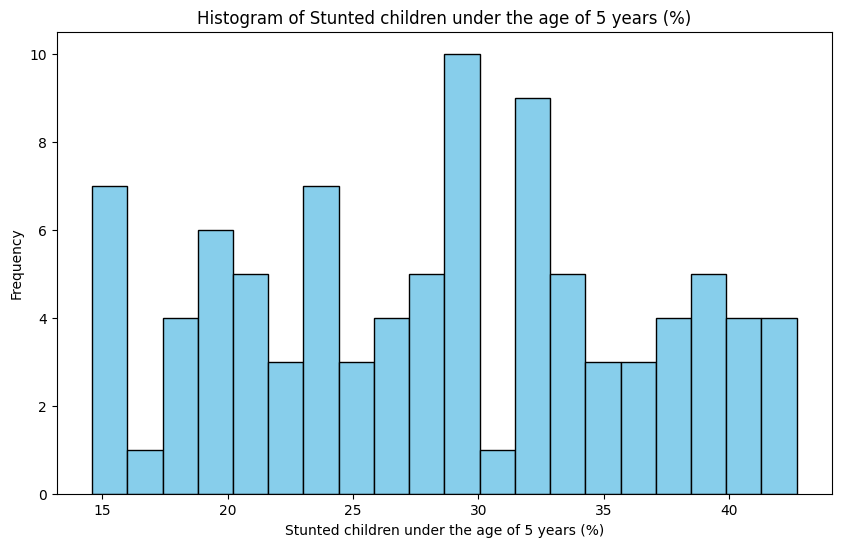

In [31]:
hist_plot('Stunted children under the age of 5 years (%)')

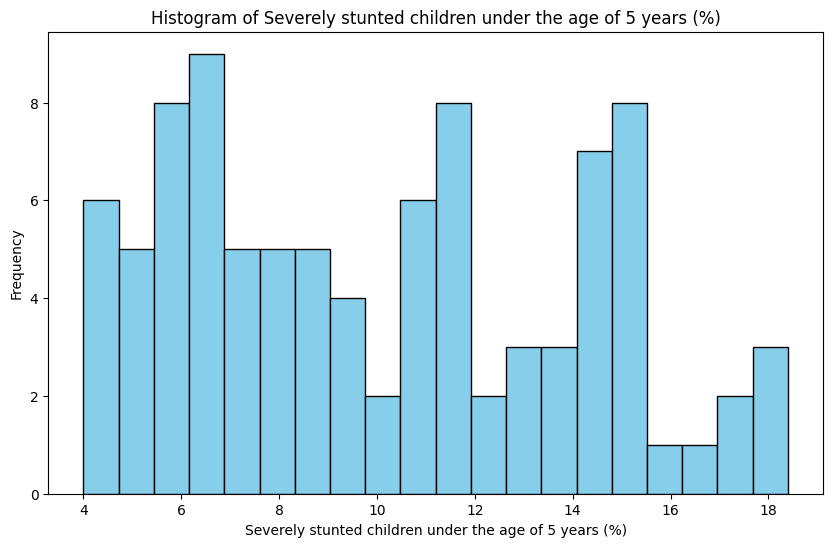

In [32]:
hist_plot('Severely stunted children under the age of 5 years (%)')

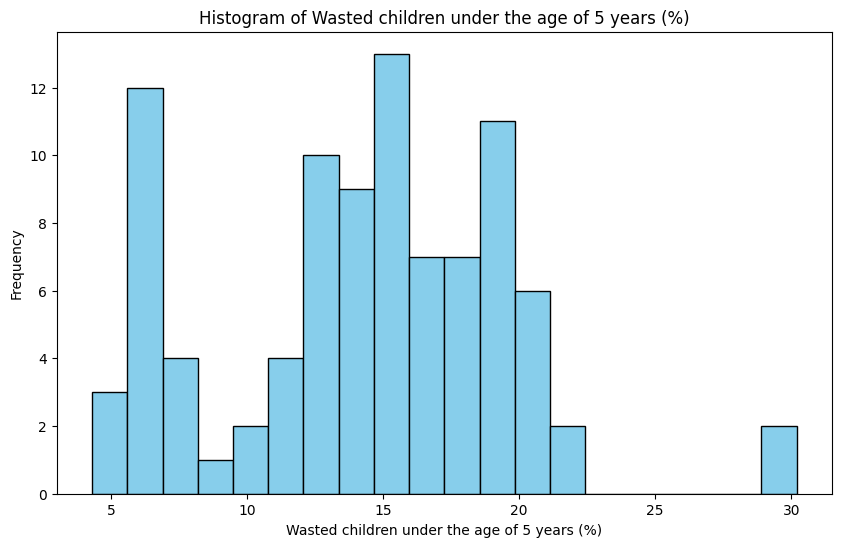

In [34]:
hist_plot('Wasted children under the age of 5 years (%)')

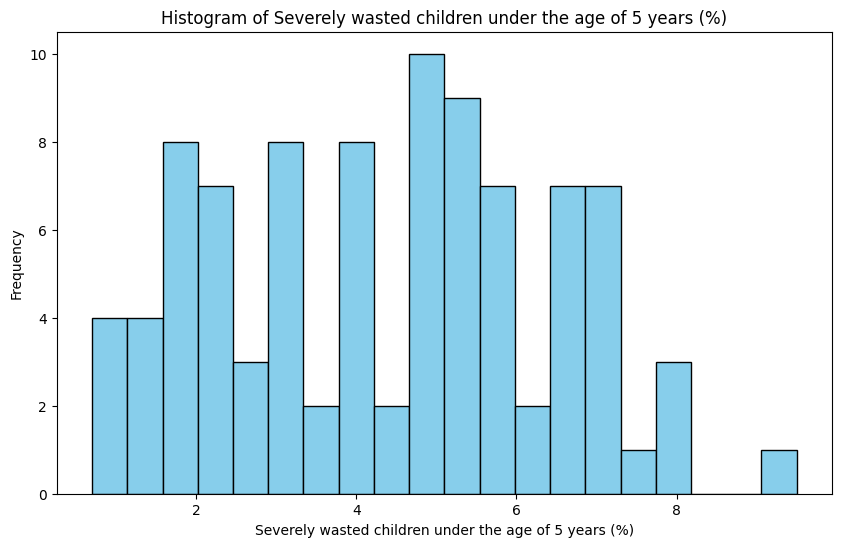

In [35]:
hist_plot('Severely wasted children under the age of 5 years (%)')

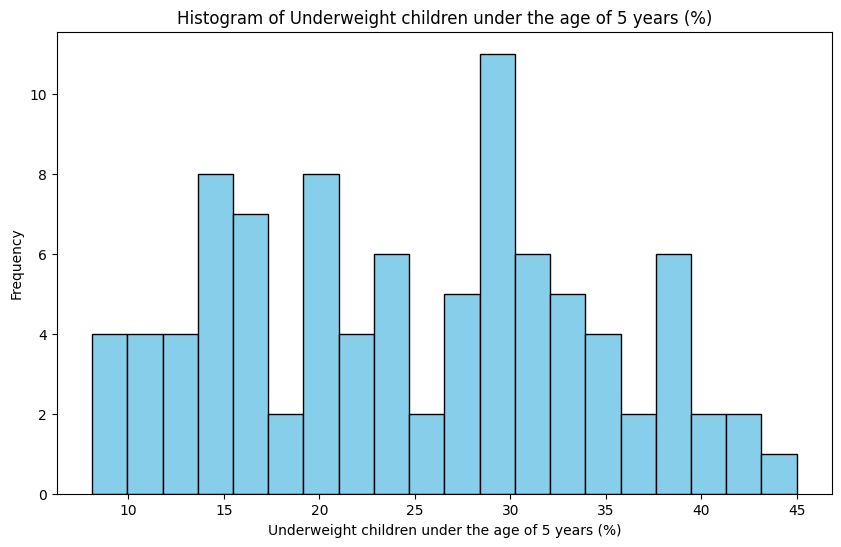

In [36]:
hist_plot('Underweight children under the age of 5 years (%)')

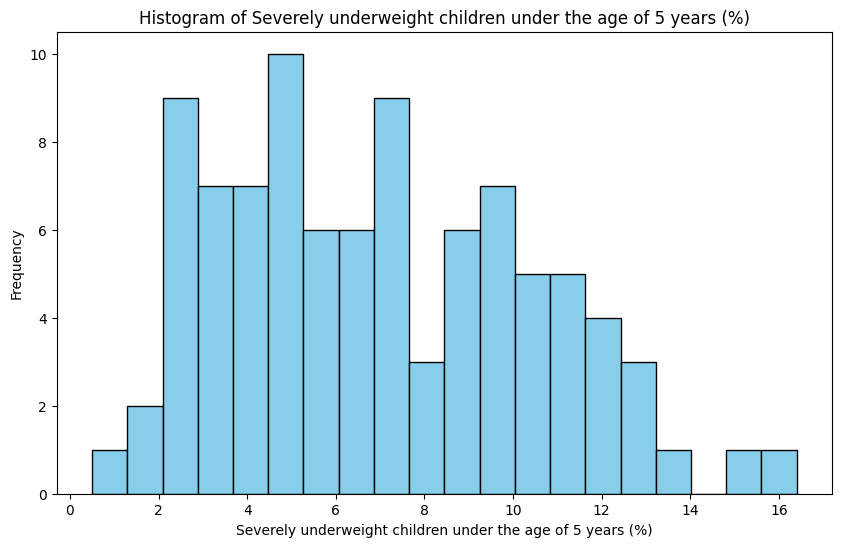

In [37]:
hist_plot('Severely underweight children under the age of 5 years (%)')

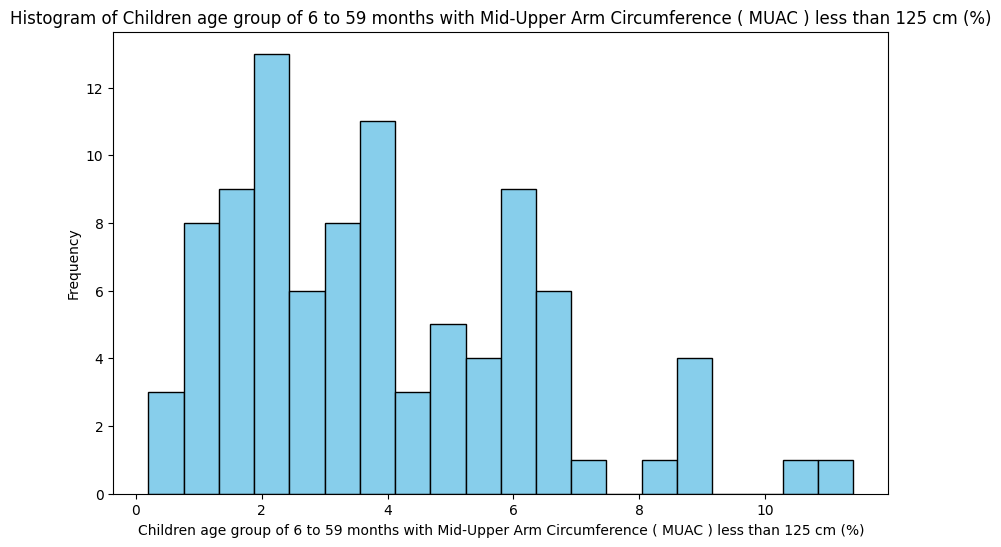

In [38]:
hist_plot('Children age group of 6 to 59 months with Mid-Upper Arm Circumference ( MUAC ) less than 125 cm (%)')

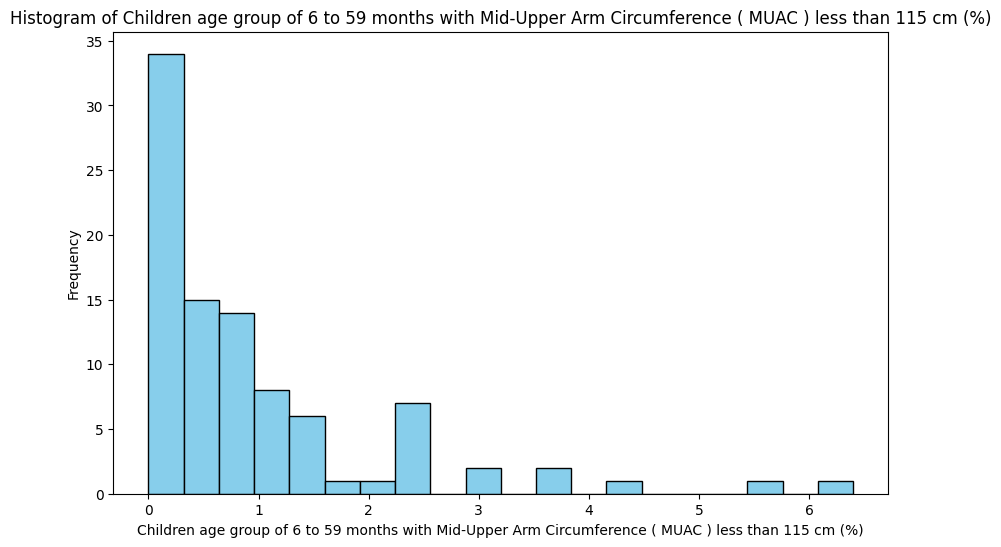

In [39]:
hist_plot('Children age group of 6 to 59 months with Mid-Upper Arm Circumference ( MUAC ) less than 115 cm (%)')

# Box plot

In [40]:
# Define a function to plot box plot for a column
def plot_boxplot(column_data, column_name):
    plt.figure(figsize=(10, 6))
    plt.boxplot(column_data, vert=False)
    plt.title(f'Box Plot of {column_name}')
    plt.xlabel(column_name)
    plt.show()

def box_plot(column_name):
    column_data = df.filter(df[column_name].isNotNull()).select(column_name).rdd.flatMap(lambda x: x).collect()
    plot_boxplot(column_data, column_name)

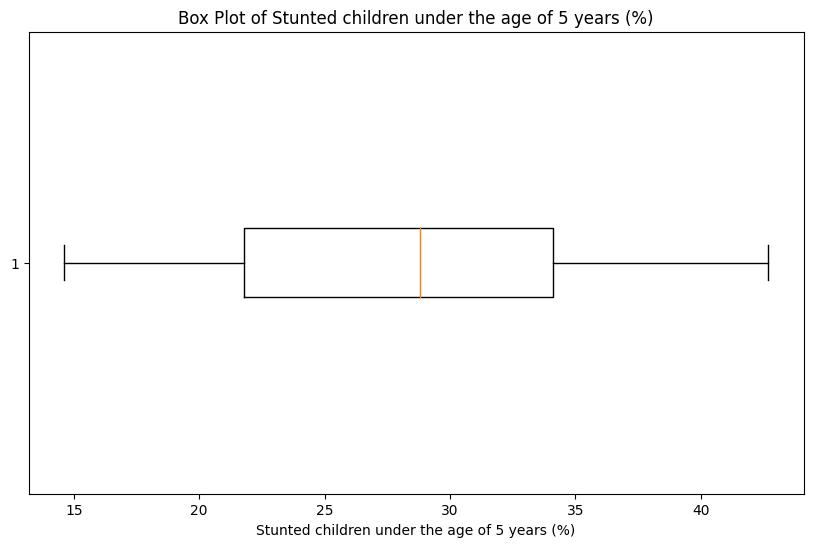

In [41]:
box_plot('Stunted children under the age of 5 years (%)')

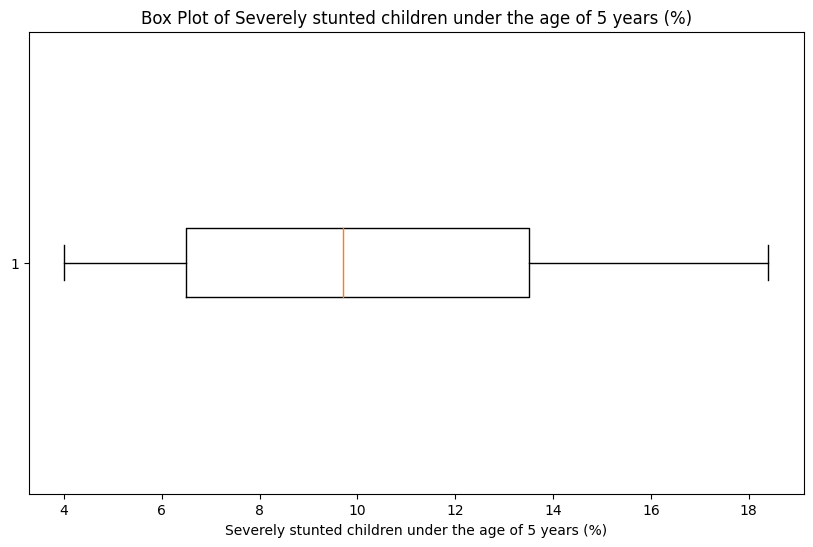

In [42]:
box_plot('Severely stunted children under the age of 5 years (%)')

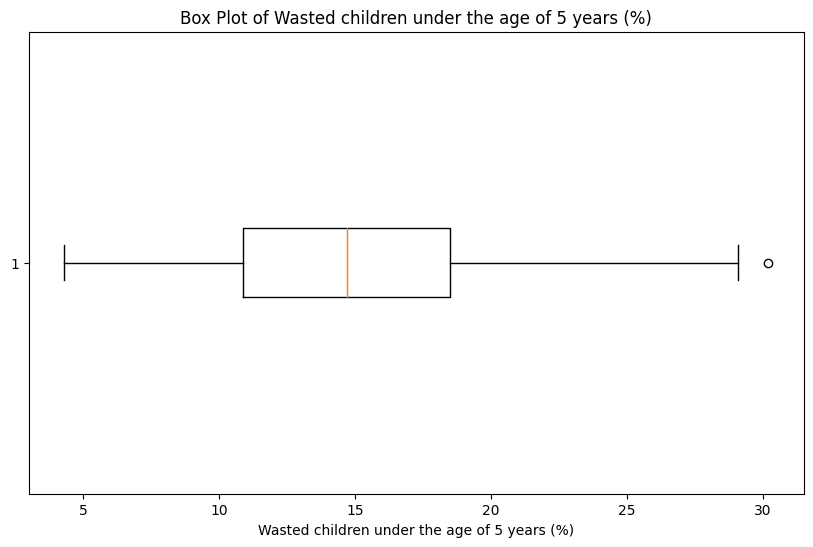

In [43]:
box_plot('Wasted children under the age of 5 years (%)')

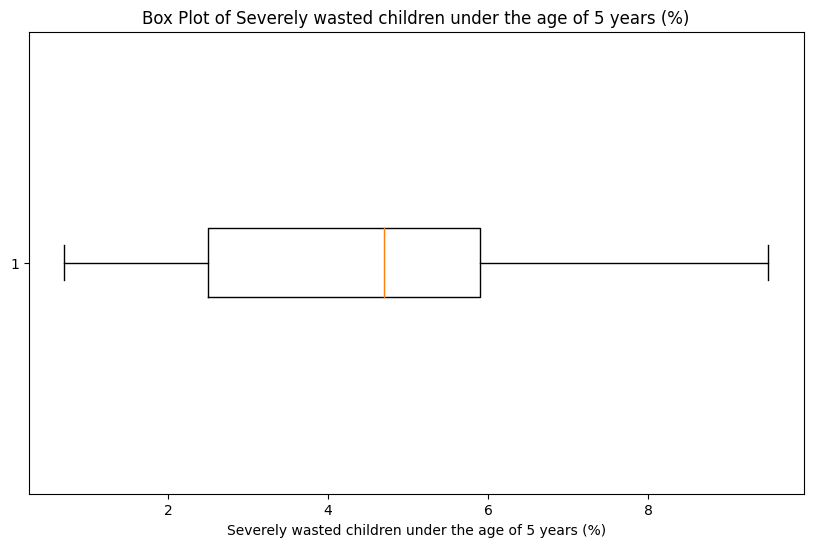

In [44]:
box_plot('Severely wasted children under the age of 5 years (%)')

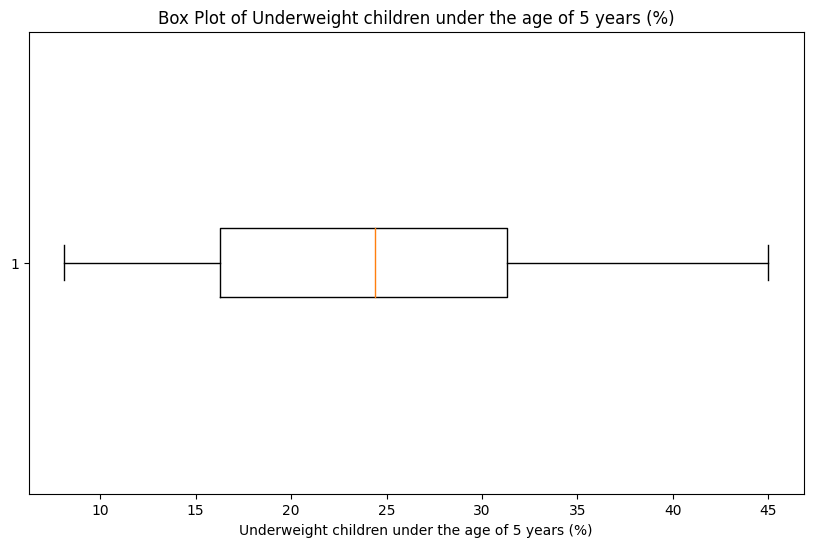

In [45]:
box_plot('Underweight children under the age of 5 years (%)')

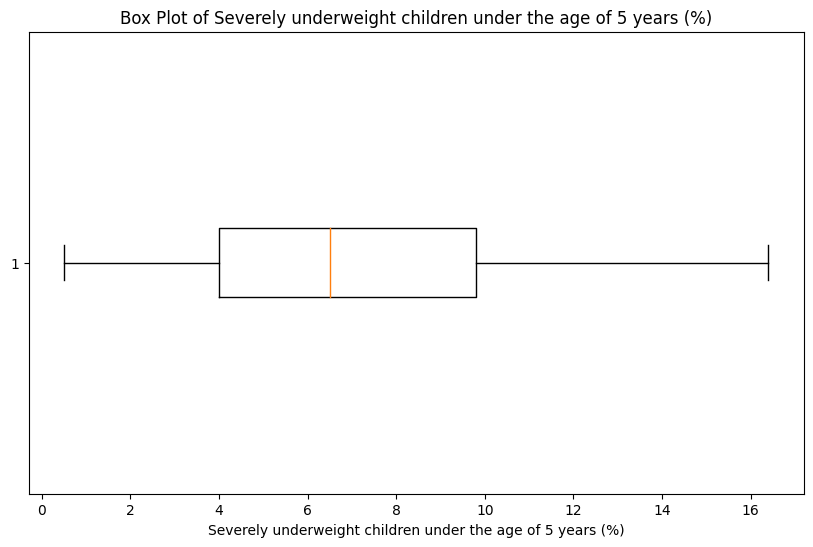

In [46]:
box_plot('Severely underweight children under the age of 5 years (%)')

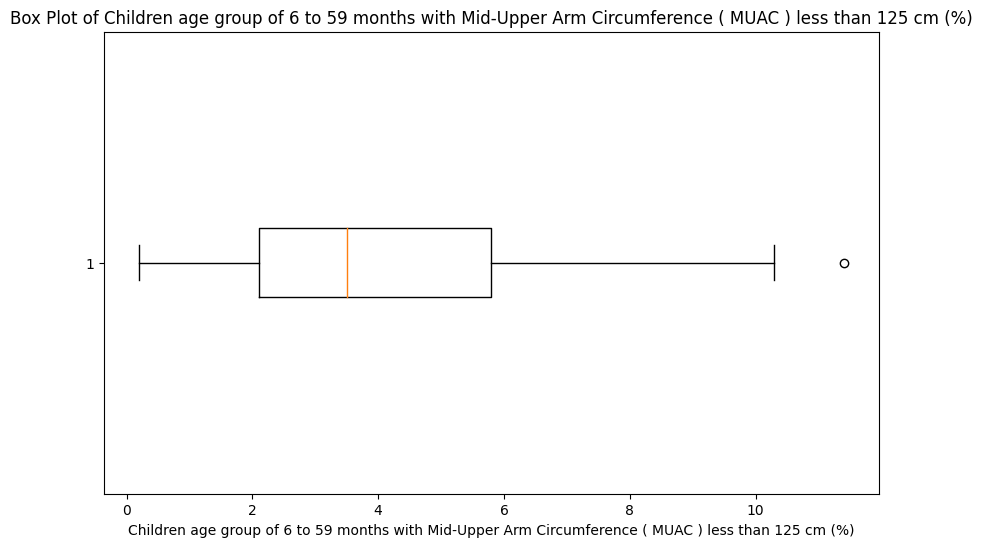

In [47]:
box_plot('Children age group of 6 to 59 months with Mid-Upper Arm Circumference ( MUAC ) less than 125 cm (%)')

# Scatter plot

In [48]:
# Define a function to plot scatter plot for a pair of columns
def plot_scatter(df, col1, col2):
    plt.figure(figsize=(10, 6))
    plt.scatter(df[col1], df[col2], alpha=0.5, color='blue')
    plt.title(f'Scatter Plot of {col1} vs {col2}')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.grid(True)
    plt.show()

# Convert Spark DataFrame to Pandas DataFrame
df_pd = df.toPandas()
def scatter_plot(col1, col2):
    plot_scatter(df_pd, col1, col2)


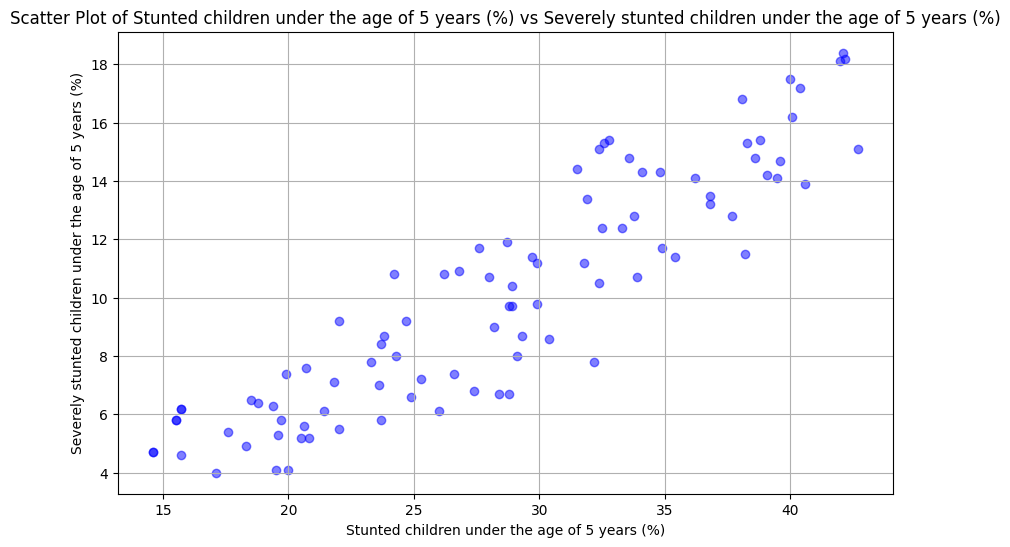

In [ ]:
scatter_plot('Stunted children under the age of 5 years (%)', 'Severely stunted children under the age of 5 years (%)')

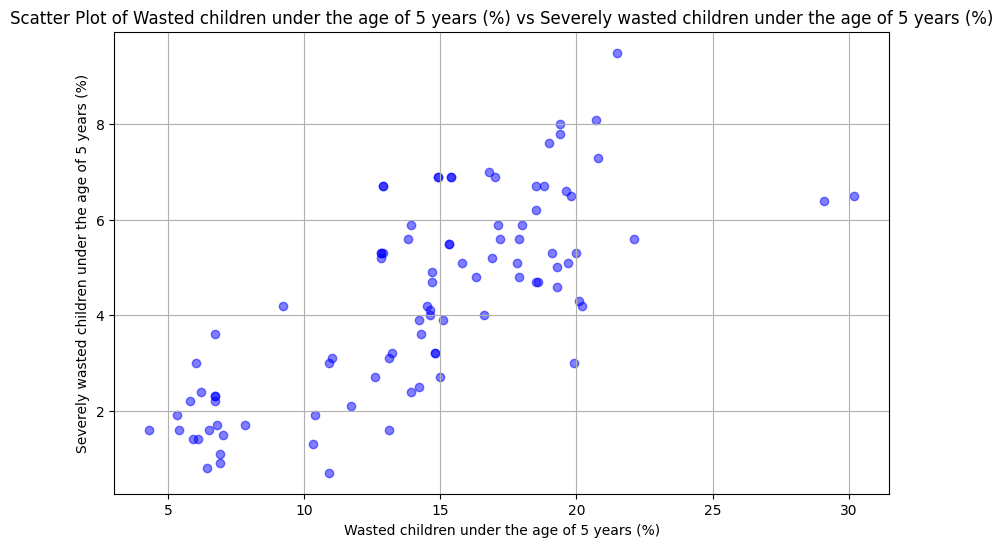

In [49]:
scatter_plot('Wasted children under the age of 5 years (%)', 'Severely wasted children under the age of 5 years (%)')

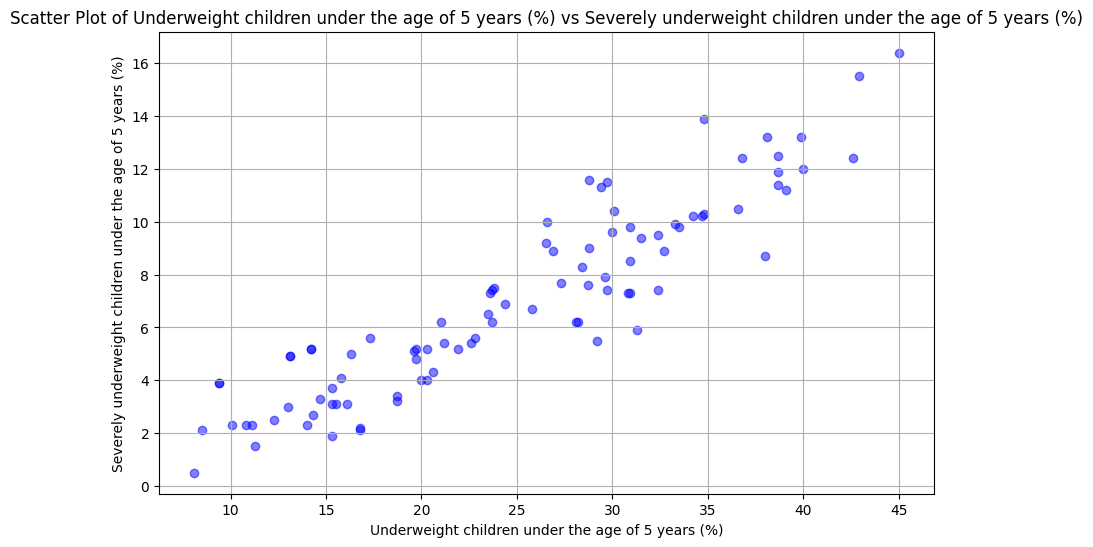

In [50]:
scatter_plot('Underweight children under the age of 5 years (%)', 'Severely underweight children under the age of 5 years (%)')


# Pie Chart

In [51]:
# Define a function to plot pie chart for a column
def plot_pie_chart(df, col_name, group_by_col):
    # Group the DataFrame by group_by_col and col_name
    grouped_df = df.groupBy(group_by_col).agg(F.mean(col_name).alias(col_name)).orderBy(group_by_col)

    # Collect data for each group within group_by_col
    labels = grouped_df.select(group_by_col).rdd.flatMap(lambda x: x).collect()
    sizes = grouped_df.select(col_name).rdd.flatMap(lambda x: x).collect()

    # Plot pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f'Pie Chart for {col_name} grouped by {group_by_col}')
    plt.axis('equal')
    plt.show()


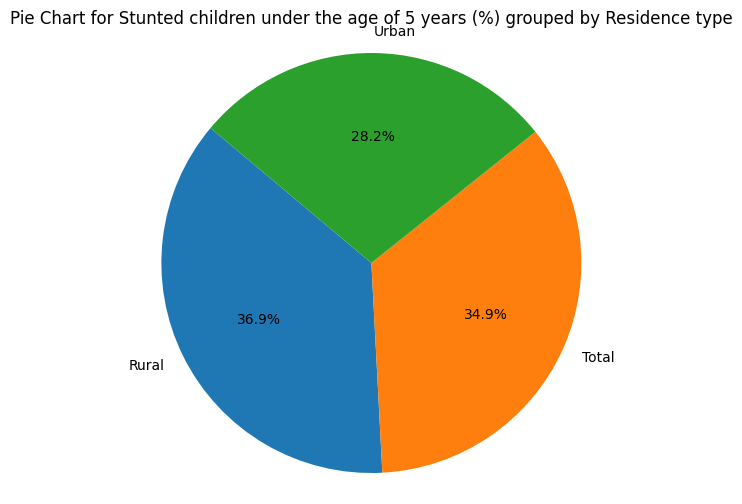

In [52]:
plot_pie_chart(df, 'Stunted children under the age of 5 years (%)', 'Residence type')

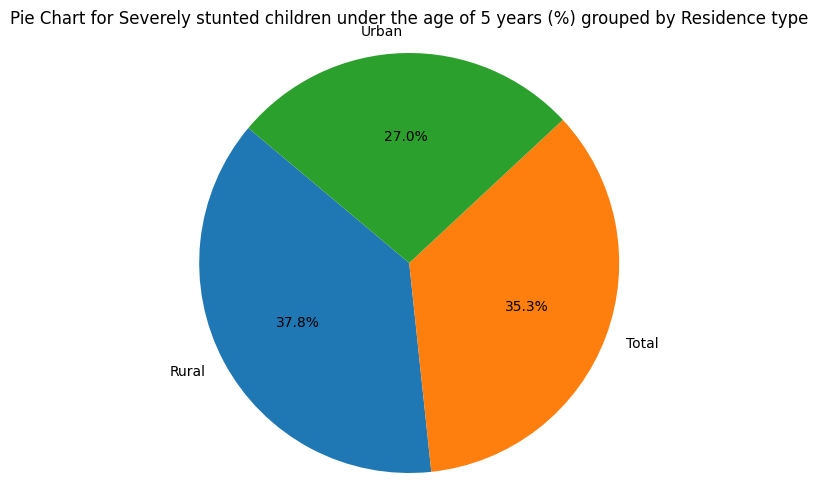

In [53]:
plot_pie_chart(df,'Severely stunted children under the age of 5 years (%)','Residence type')

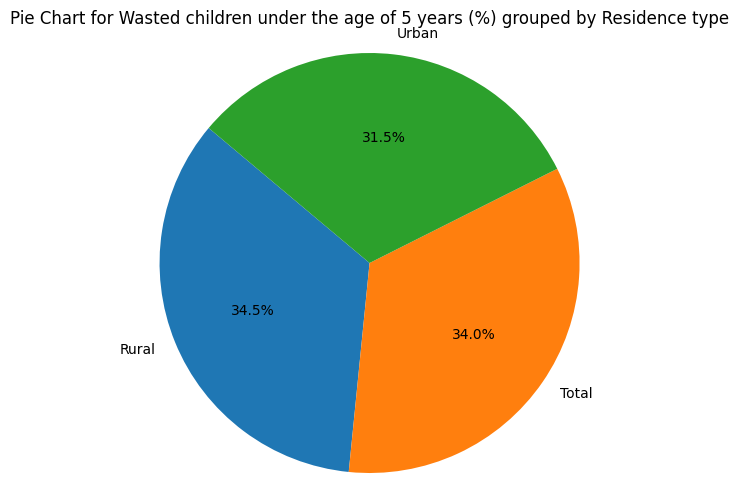

In [54]:
plot_pie_chart(df, 'Wasted children under the age of 5 years (%)', 'Residence type')

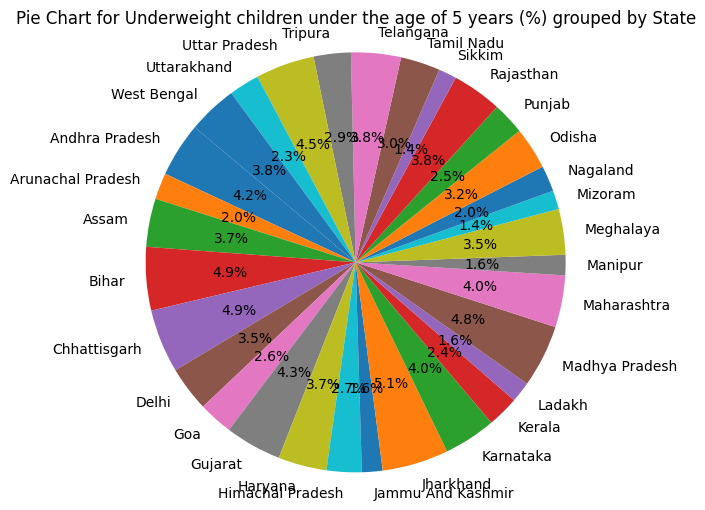

In [55]:
# Call the function with specified column names and group_by column
plot_pie_chart(df,'Underweight children under the age of 5 years (%)','State')

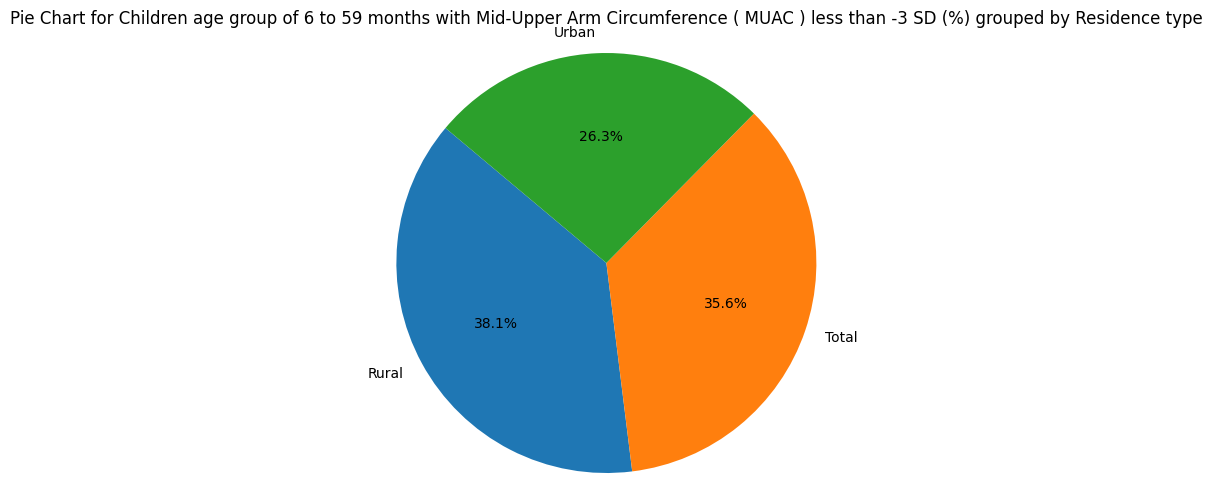

In [56]:
plot_pie_chart(df, 'Children age group of 6 to 59 months with Mid-Upper Arm Circumference ( MUAC ) less than -3 SD (%)', 'Residence type')

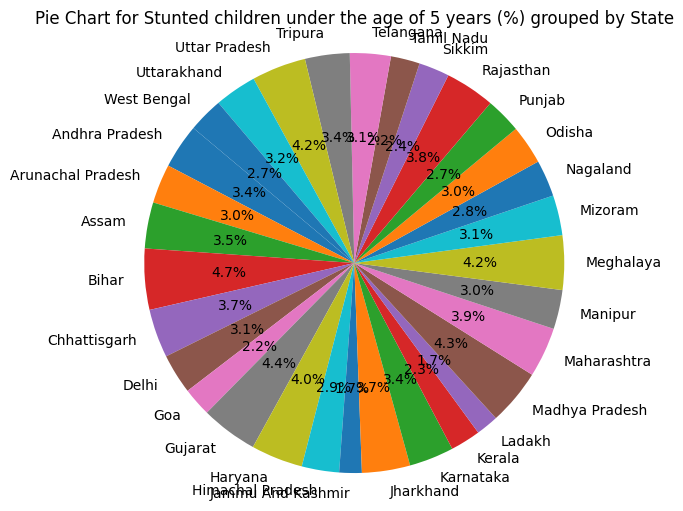

In [57]:
plot_pie_chart(df, 'Stunted children under the age of 5 years (%)', 'State')

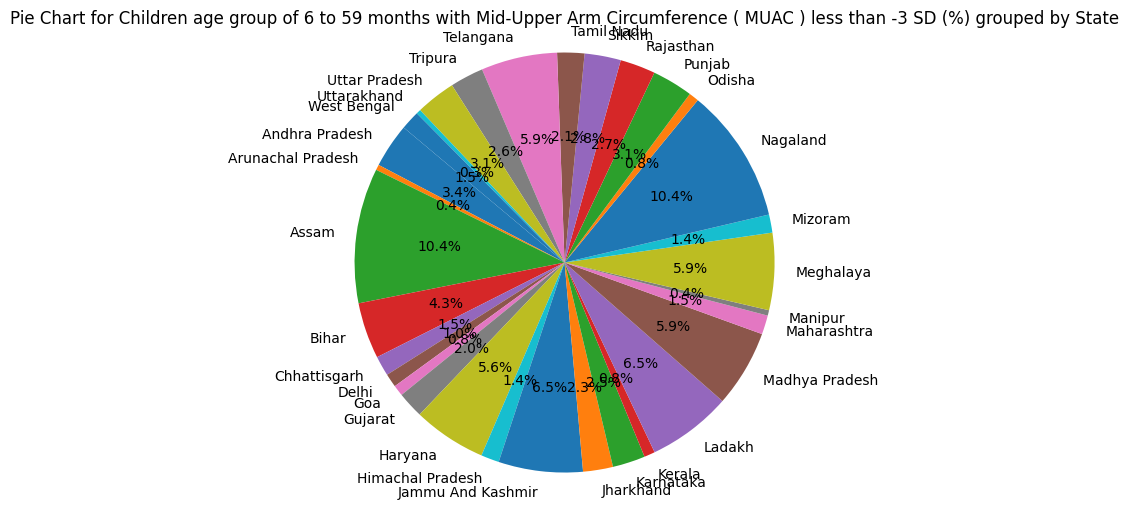

In [58]:
plot_pie_chart(df, 'Children age group of 6 to 59 months with Mid-Upper Arm Circumference ( MUAC ) less than -3 SD (%)', 'State')

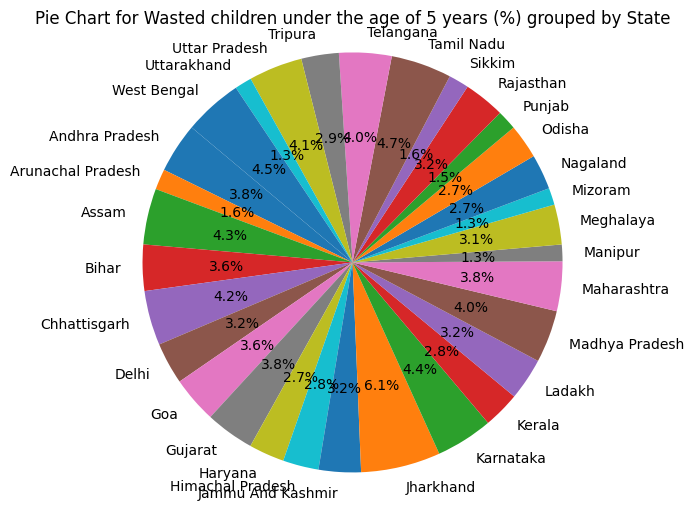

In [59]:
plot_pie_chart(df, 'Wasted children under the age of 5 years (%)', 'State')

# Correlation matrix

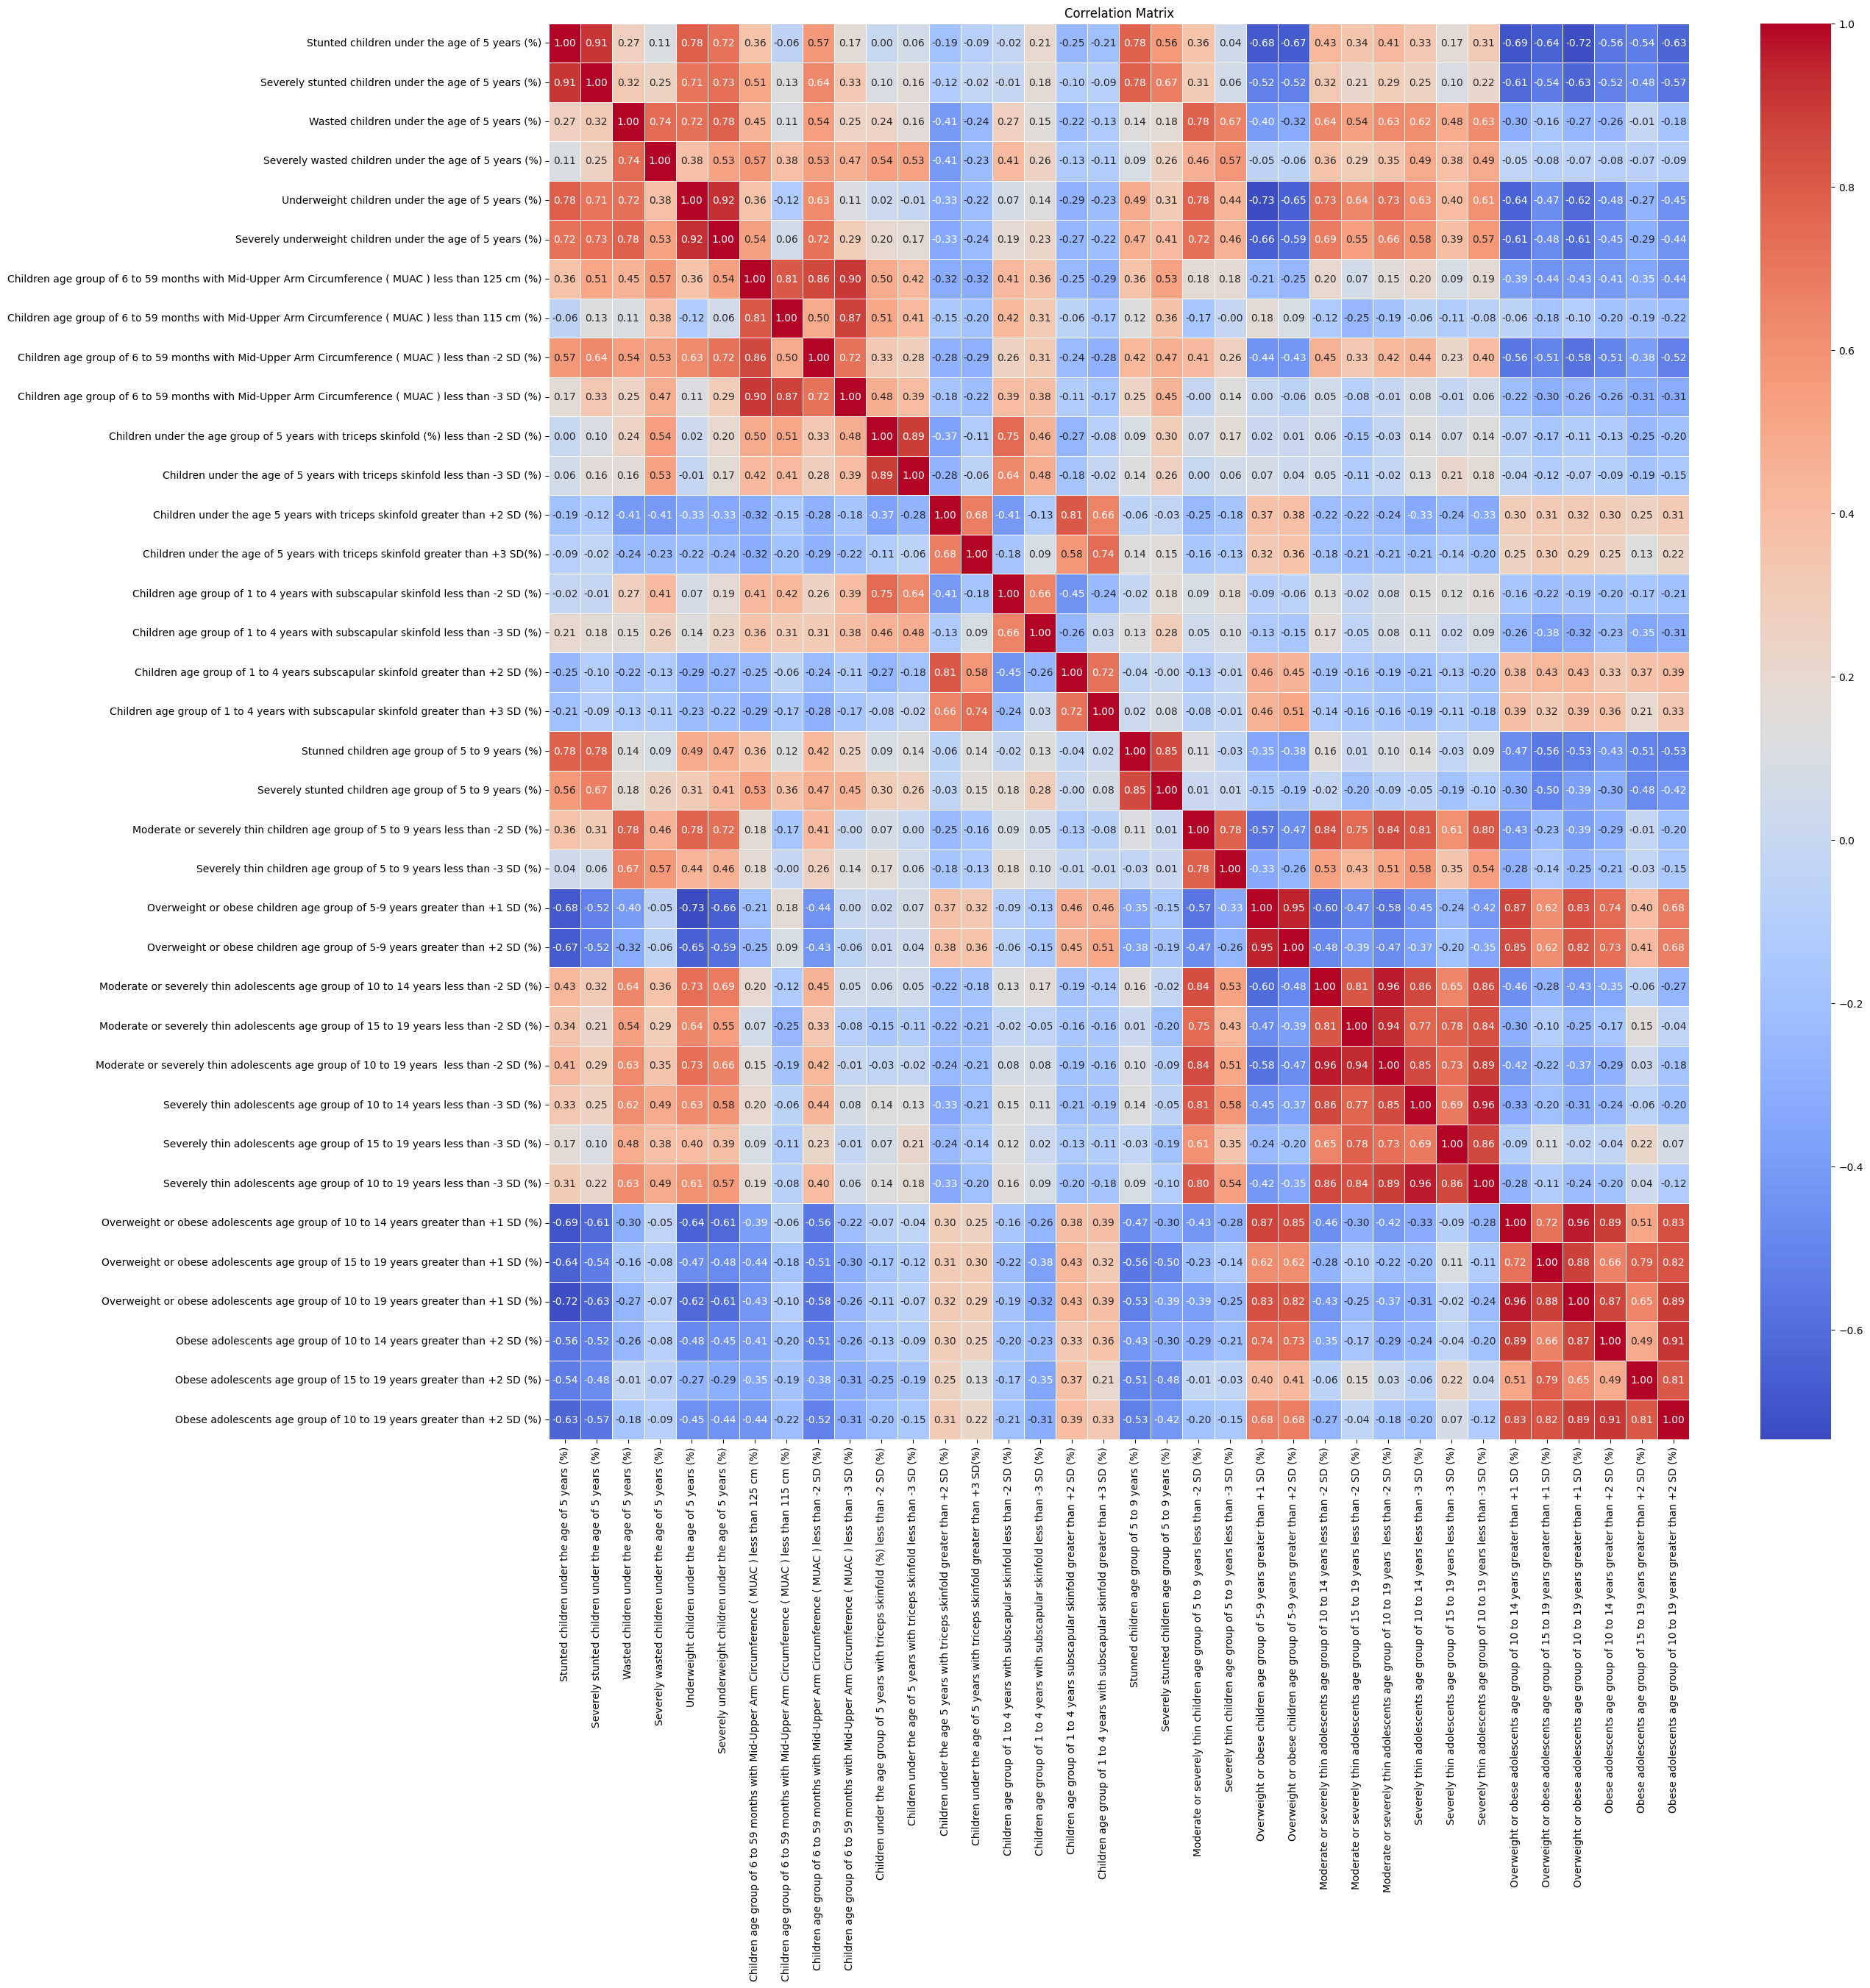

In [63]:
# Drop columns with string attributes
numeric_columns = [col_name for col_name, data_type in df.dtypes if data_type == "double"]
df = df.select(numeric_columns)

# Convert Spark DataFrame to Pandas DataFrame
df_pd = df.toPandas()

# Calculate correlation matrix
correlation_matrix = df_pd.corr()

# Plot correlation matrix heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Linear Regression

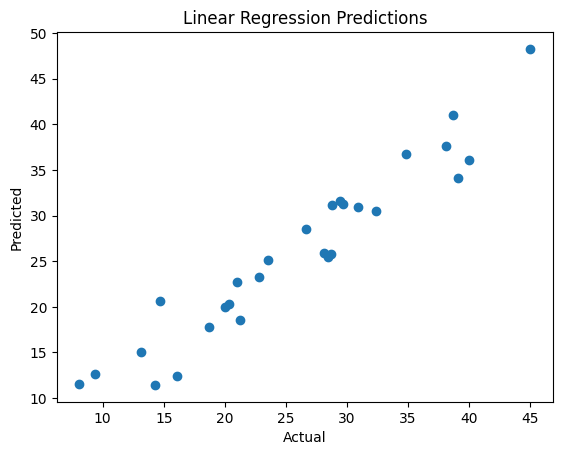

In [61]:
selected_columns = [
    "Stunted children under the age of 5 years (%)",
    "Severely stunted children under the age of 5 years (%)",
    "Wasted children under the age of 5 years (%)",
]

# Assemble features
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
assembled_df = assembler.transform(df)
target_column = "Underweight children under the age of 5 years (%)"
assembled_df = assembled_df.select("features", target_column)
train_data, test_data = assembled_df.randomSplit([0.7, 0.3])
lr = LinearRegression(featuresCol="features", labelCol=target_column)

# Fit the model
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)
preds_and_labels = predictions.select("prediction", target_column).rdd.map(lambda row: (float(row[0]), float(row[1]))).collect()

# Plotting
preds, labels = zip(*preds_and_labels)
plt.scatter(labels, preds)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression Predictions")
plt.show()



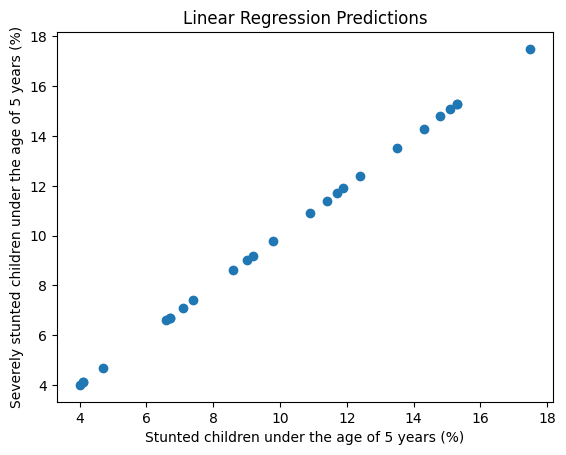

In [ ]:
# Select relevant columns
selected_columns = [
    "Stunted children under the age of 5 years (%)",
    "Severely stunted children under the age of 5 years (%)"
]

# Drop rows with null values in selected columns
df = df.dropna(subset=selected_columns)
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
assembled_df = assembler.transform(df)
target_column = "Severely stunted children under the age of 5 years (%)"
assembled_df = assembled_df.select("features", target_column)

# Split data into training and test sets
train_data, test_data = assembled_df.randomSplit([0.7, 0.3])
lr = LinearRegression(featuresCol="features", labelCol=target_column)

# Fit the model
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)
preds_and_labels = predictions.select("prediction", target_column).rdd.map(lambda row: (float(row[0]), float(row[1]))).collect()

# Plotting
preds, labels = zip(*preds_and_labels)
plt.scatter(labels, preds)
plt.xlabel("Stunted children under the age of 5 years (%)")
plt.ylabel("Severely stunted children under the age of 5 years (%)")
plt.title("Linear Regression Predictions")
plt.show()

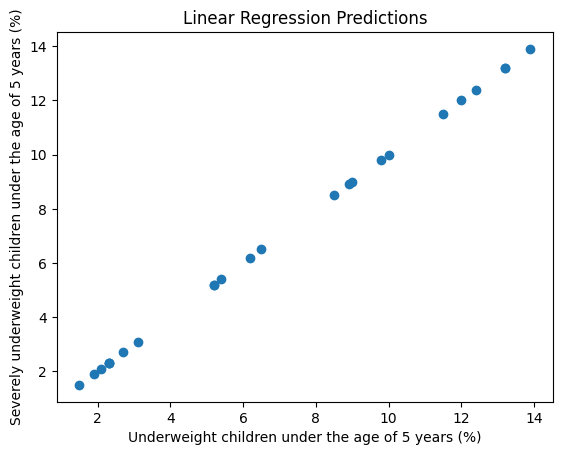

In [ ]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("LinearRegressionExample") \
    .getOrCreate()

# Load dataset
df = spark.read.csv("NDAP_REPORT_7045.csv", header=True, inferSchema=True)

# Select relevant columns
selected_columns = [
    "Underweight children under the age of 5 years (%)",
    "Severely underweight children under the age of 5 years (%)"
]

# Drop rows with null values in selected columns
df = df.dropna(subset=selected_columns)

# Assemble features
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
assembled_df = assembler.transform(df)

# Select target column
target_column = "Severely underweight children under the age of 5 years (%)"
assembled_df = assembled_df.select("features", target_column)

# Split data into training and test sets
train_data, test_data = assembled_df.randomSplit([0.7, 0.3])

# Create Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol=target_column)

# Fit the model
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Extract predictions and labels for plotting
preds_and_labels = predictions.select("prediction", target_column).rdd.map(lambda row: (float(row[0]), float(row[1]))).collect()

# Plotting
preds, labels = zip(*preds_and_labels)
plt.scatter(labels, preds)
plt.xlabel("Underweight children under the age of 5 years (%)")
plt.ylabel("Severely underweight children under the age of 5 years (%)")
plt.title("Linear Regression Predictions")
plt.show()

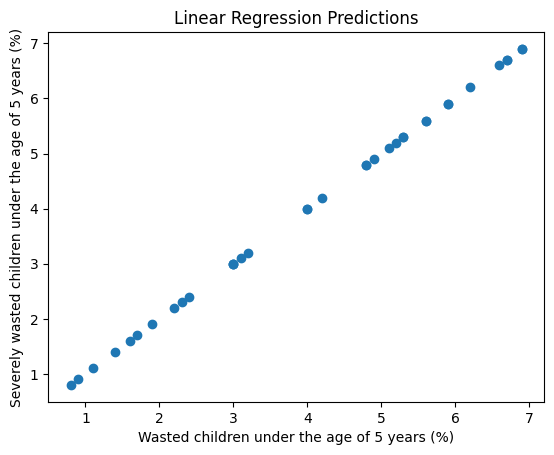

In [ ]:
# Select relevant columns
selected_columns = [
    "Wasted children under the age of 5 years (%)",
    "Severely wasted children under the age of 5 years (%)"
]

# Drop rows with null values in selected columns
df = df.dropna(subset=selected_columns)

# Assemble features
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
assembled_df = assembler.transform(df)

# Select target column
target_column = "Severely wasted children under the age of 5 years (%)"
assembled_df = assembled_df.select("features", target_column)

# Split data into training and test sets
train_data, test_data = assembled_df.randomSplit([0.7, 0.3])

# Create Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol=target_column)

# Fit the model
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Extract predictions and labels for plotting
preds_and_labels = predictions.select("prediction", target_column).rdd.map(lambda row: (float(row[0]), float(row[1]))).collect()

# Plotting
preds, labels = zip(*preds_and_labels)
plt.scatter(labels, preds)
plt.xlabel("Wasted children under the age of 5 years (%)")
plt.ylabel("Severely wasted children under the age of 5 years (%)")
plt.title("Linear Regression Predictions")
plt.show()

# Stop SparkSession
spark.stop()


# K-means Clustering

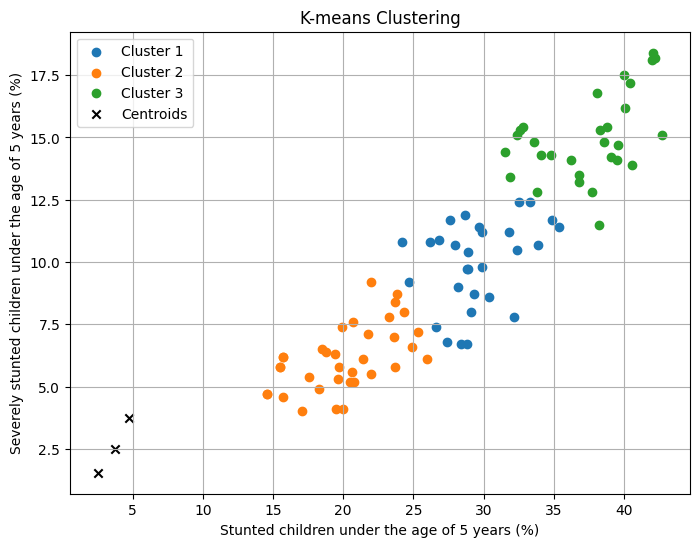

In [ ]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("KMeans Clustering") \
    .getOrCreate()

# Read the CSV file
df = spark.read.csv("NDAP_REPORT_7045.csv", header=True, inferSchema=True)

# Select appropriate columns for clustering
columns_for_clustering = ['Stunted children under the age of 5 years (%)',
                          'Severely stunted children under the age of 5 years (%)']

# Assemble the features vector
assembler = VectorAssembler(inputCols=columns_for_clustering, outputCol="features")
data = assembler.transform(df)

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(data)
scaled_data = scaler_model.transform(data)

# Define the number of clusters
num_clusters = 3

# Apply K-means clustering
kmeans = KMeans(featuresCol="scaledFeatures", predictionCol="cluster", k=num_clusters)
model = kmeans.fit(scaled_data)
predictions = model.transform(scaled_data)

# Get cluster centers
cluster_centers = model.clusterCenters()

# Convert cluster centers to Pandas DataFrame for visualization
import numpy as np
cluster_centers_pd = pd.DataFrame(np.array(cluster_centers), columns=columns_for_clustering)

# Visualize the clusters
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    cluster_data = predictions.filter(predictions['cluster'] == i).select(columns_for_clustering).toPandas()
    plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=f'Cluster {i+1}')

plt.scatter(cluster_centers_pd.iloc[:, 0], cluster_centers_pd.iloc[:, 1], marker='x', color='black', label='Centroids')
plt.xlabel(columns_for_clustering[0])
plt.ylabel(columns_for_clustering[1])
plt.title('K-means Clustering')
plt.legend()
plt.grid(True)
plt.show()

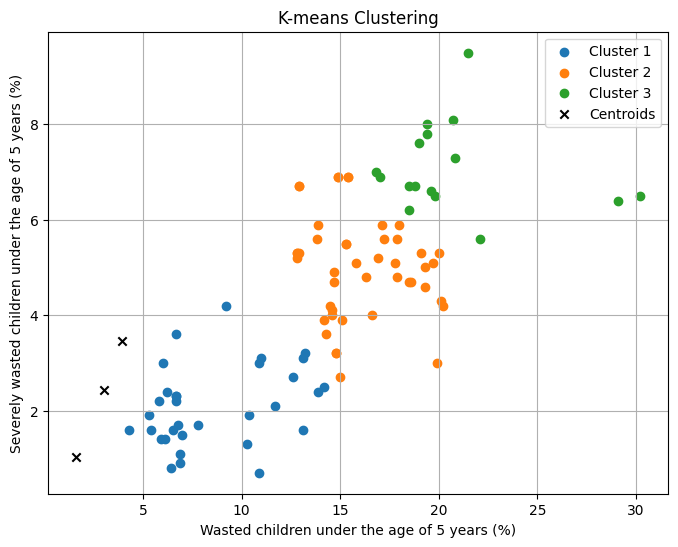

In [ ]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("KMeans Clustering") \
    .getOrCreate()

# Read the CSV file
df = spark.read.csv("NDAP_REPORT_7045.csv", header=True, inferSchema=True)

# Select appropriate columns for clustering
columns_for_clustering = ['Wasted children under the age of 5 years (%)',
                          'Severely wasted children under the age of 5 years (%)']

# Assemble the features vector
assembler = VectorAssembler(inputCols=columns_for_clustering, outputCol="features")
data = assembler.transform(df)

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(data)
scaled_data = scaler_model.transform(data)

# Define the number of clusters
num_clusters = 3

# Apply K-means clustering
kmeans = KMeans(featuresCol="scaledFeatures", predictionCol="cluster", k=num_clusters)
model = kmeans.fit(scaled_data)
predictions = model.transform(scaled_data)

# Get cluster centers
cluster_centers = model.clusterCenters()

# Convert cluster centers to Pandas DataFrame for visualization
import numpy as np
cluster_centers_pd = pd.DataFrame(np.array(cluster_centers), columns=columns_for_clustering)

# Visualize the clusters
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    cluster_data = predictions.filter(predictions['cluster'] == i).select(columns_for_clustering).toPandas()
    plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=f'Cluster {i+1}')

plt.scatter(cluster_centers_pd.iloc[:, 0], cluster_centers_pd.iloc[:, 1], marker='x', color='black', label='Centroids')
plt.xlabel(columns_for_clustering[0])
plt.ylabel(columns_for_clustering[1])
plt.title('K-means Clustering')
plt.legend()
plt.grid(True)
plt.show()


# GMM Clustering

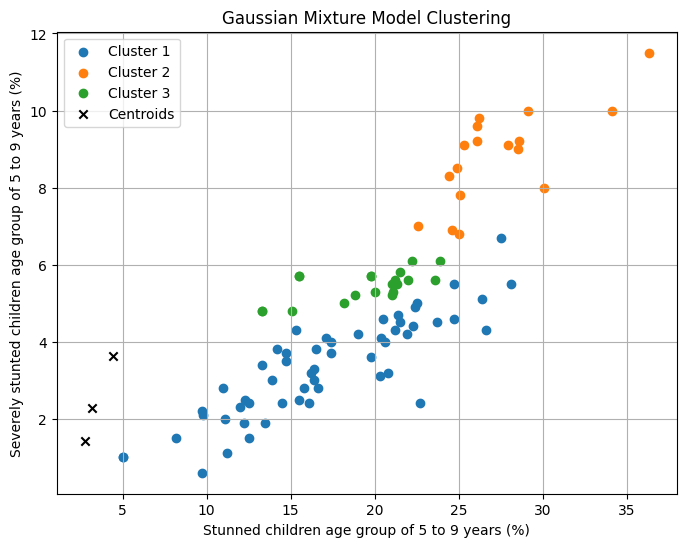

In [8]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Gaussian Mixture Model Clustering") \
    .getOrCreate()

# Read the CSV file
df = spark.read.csv("NDAP_REPORT_7045.csv", header=True, inferSchema=True)

# Select appropriate columns for clustering
columns_for_clustering = ['Stunned children age group of 5 to 9 years (%)', 'Severely stunted children age group of 5 to 9 years (%)']

# Assemble the features vector
assembler = VectorAssembler(inputCols=columns_for_clustering, outputCol="features")
data = assembler.transform(df)

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(data)
scaled_data = scaler_model.transform(data)

# Define the number of clusters
num_clusters = 3

# Apply Gaussian Mixture Model clustering
gmm = GaussianMixture(featuresCol="scaledFeatures", predictionCol="cluster", k=num_clusters)
model = gmm.fit(scaled_data)
predictions = model.transform(scaled_data)

# Get cluster centers
cluster_centers = model.gaussiansDF.select('mean').collect()

# Convert cluster centers to Pandas DataFrame for visualization
cluster_centers_pd = pd.DataFrame(np.array([c[0] for c in cluster_centers]), columns=columns_for_clustering)

# Visualize the clusters
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    cluster_data = predictions.filter(predictions['cluster'] == i).select(columns_for_clustering).toPandas()
    plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=f'Cluster {i+1}')

plt.scatter(cluster_centers_pd.iloc[:, 0], cluster_centers_pd.iloc[:, 1], marker='x', color='black', label='Centroids')
plt.xlabel(columns_for_clustering[0])
plt.ylabel(columns_for_clustering[1])
plt.title('Gaussian Mixture Model Clustering')
plt.legend()
plt.grid(True)
plt.show()


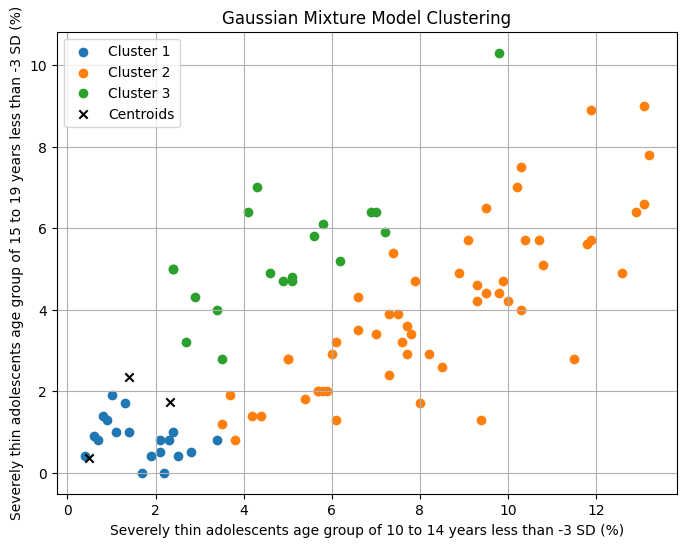

In [9]:
# Select appropriate columns for clustering
columns_for_clustering = ['Severely thin adolescents age group of 10 to 14 years less than -3 SD (%)', 'Severely thin adolescents age group of 15 to 19 years less than -3 SD (%)']

# Assemble the features vector
assembler = VectorAssembler(inputCols=columns_for_clustering, outputCol="features")
data = assembler.transform(df)

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(data)
scaled_data = scaler_model.transform(data)

# Define the number of clusters
num_clusters = 3

# Apply Gaussian Mixture Model clustering
gmm = GaussianMixture(featuresCol="scaledFeatures", predictionCol="cluster", k=num_clusters)
model = gmm.fit(scaled_data)
predictions = model.transform(scaled_data)

# Get cluster centers
cluster_centers = model.gaussiansDF.select('mean').collect()

# Convert cluster centers to Pandas DataFrame for visualization
cluster_centers_pd = pd.DataFrame(np.array([c[0] for c in cluster_centers]), columns=columns_for_clustering)

# Visualize the clusters
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    cluster_data = predictions.filter(predictions['cluster'] == i).select(columns_for_clustering).toPandas()
    plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=f'Cluster {i+1}')

plt.scatter(cluster_centers_pd.iloc[:, 0], cluster_centers_pd.iloc[:, 1], marker='x', color='black', label='Centroids')
plt.xlabel(columns_for_clustering[0])
plt.ylabel(columns_for_clustering[1])
plt.title('Gaussian Mixture Model Clustering')
plt.legend()
plt.grid(True)
plt.show()


# Line plot

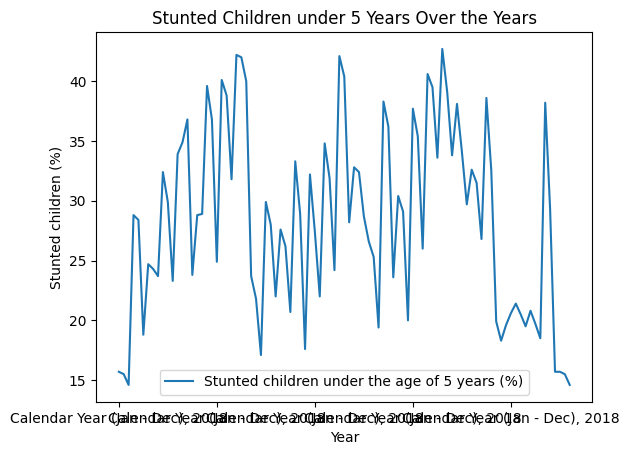

In [14]:
# Convert the Spark DataFrame into a Pandas DataFrame
pandas_df = df.toPandas()
pandas_df.plot(x='Year', y='Stunted children under the age of 5 years (%)', kind='line')
plt.xlabel('Year')
plt.ylabel('Stunted children (%)')
plt.title('Stunted Children under 5 Years Over the Years')
plt.show()

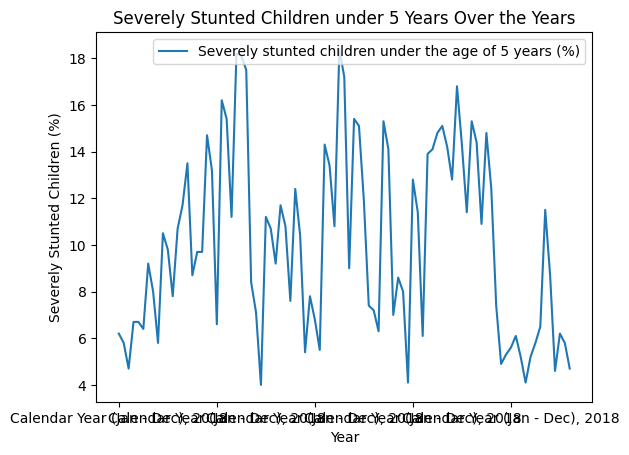

In [15]:
# Plotting another appropriate column, for example, 'Severely stunted children under the age of 5 years (%)'
pandas_df.plot(x='Year', y='Severely stunted children under the age of 5 years (%)', kind='line')
plt.xlabel('Year')
plt.ylabel('Severely Stunted Children (%)')
plt.title('Severely Stunted Children under 5 Years Over the Years')
plt.show()